In [2]:
!pip install torch torchvision diffusers transformers accelerate
!pip install optimum

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from diffusers import StableDiffusionPipeline, DDPMScheduler
from transformers import CLIPTokenizer, get_linear_schedule_with_warmup
from accelerate import Accelerator
import gc
import matplotlib.pyplot as plt
import bitsandbytes as bnb

# Set up paths and parameters
dataset_path = "/notebooks/Dataset/colors-of-van-gogh/vincent-van-gogh/vincent-van-gogh"
output_dir = "/notebooks/Working/van-gogh-model"
model_name = "stabilityai/stable-diffusion-2-1"
num_epochs = 15
steps_per_epoch = 300
batch_size = 1
learning_rate = 5e-6
gradient_accumulation_steps = 4

# Custom dataset class
class VanGoghDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_paths = []
        self.labels = []

        for class_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(class_name)

        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        return image, label

# Function to plot images
def plot_images(images):
    plt.figure(figsize=(20, 10))
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# Set up Accelerator
accelerator = Accelerator(
    gradient_accumulation_steps=gradient_accumulation_steps,
)

# Load dataset
dataset = VanGoghDataset(dataset_path)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Load model and tokenizer
pipe = StableDiffusionPipeline.from_pretrained(model_name, torch_dtype=torch.float32)
tokenizer = CLIPTokenizer.from_pretrained(model_name, subfolder="tokenizer")

# Move model components to the appropriate device and convert to float32
pipe.to(accelerator.device)
pipe.unet.to(dtype=torch.float32)
pipe.vae.to(dtype=torch.float32)
pipe.text_encoder.to(dtype=torch.float32)

# Set up Adam optimizer
optimizer = torch.optim.AdamW(pipe.unet.parameters(), lr=learning_rate)

noise_scheduler = DDPMScheduler.from_config(pipe.scheduler.config)

# Set up learning rate scheduler
total_steps = num_epochs * steps_per_epoch
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=100, num_training_steps=total_steps
)

# Prepare for distributed training
pipe.unet, optimizer, dataloader, scheduler = accelerator.prepare(
    pipe.unet, optimizer, dataloader, scheduler
)

# Training loop
for epoch in range(num_epochs):
    for step, (images, labels) in enumerate(dataloader):
        if step >= steps_per_epoch:
            break

        with accelerator.accumulate(pipe.unet):
            # Convert images to the model's dtype and move to the correct device
            images = images.to(device=accelerator.device, dtype=torch.float32)

            # Convert images to latent space
            latents = pipe.vae.encode(images).latent_dist.sample()
            latents = latents * 0.18215

            # Sample noise
            noise = torch.randn_like(latents)
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (batch_size,), device=latents.device)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Get text embeddings
            text_input = tokenizer(labels, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
            encoder_hidden_states = pipe.text_encoder(text_input.input_ids.to(latents.device))[0]

            # Predict noise
            noise_pred = pipe.unet(noisy_latents, timesteps, encoder_hidden_states).sample

            # Calculate loss
            loss = torch.nn.functional.mse_loss(noise_pred, noise)

            # Backpropagate and update
            accelerator.backward(loss)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        if step % 10 == 0:
            print(f"Epoch {epoch}, Step {step}: Loss {loss.item()}")

# Save the fine-tuned model
accelerator.wait_for_everyone()
unwrapped_unet = accelerator.unwrap_model(pipe.unet)
pipe.unet = unwrapped_unet
pipe.to(device=pipe.device, dtype=torch.float16)  # Convert back to float16 for saving
pipe.save_pretrained(output_dir)
print("Fine-tuning complete. Model saved.")

# Generate sample images
prompt = "A painting of a sunflower field in the style of Van Gogh"
images = pipe(prompt, num_images_per_prompt=4).images
plot_images(images)

# Clean up
del pipe
del images
gc.collect()
torch.cuda.empty_cache()

2024-07-01 13:53:20.372892: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 13:53:20.372964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 13:53:20.374748: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-01 13:53:20.384668: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-01 13:53:21.617950: W tensorflow/compiler/tf2

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 0, Step 0: Loss 1.0820306539535522
Epoch 0, Step 10: Loss 0.6210995316505432
Epoch 0, Step 20: Loss 1.417159080505371
Epoch 0, Step 30: Loss 1.2462013959884644
Epoch 0, Step 40: Loss 0.8024165630340576
Epoch 0, Step 50: Loss 1.0282139778137207
Epoch 0, Step 60: Loss 0.8096698522567749
Epoch 0, Step 70: Loss 1.016491174697876
Epoch 0, Step 80: Loss 1.1945910453796387
Epoch 0, Step 90: Loss 0.917874276638031
Epoch 0, Step 100: Loss 0.6296675205230713
Epoch 0, Step 110: Loss 0.7096558213233948
Epoch 0, Step 120: Loss 0.7309210300445557
Epoch 0, Step 130: Loss 0.7528262734413147
Epoch 0, Step 140: Loss 1.2665687799453735
Epoch 0, Step 150: Loss 0.5170431137084961
Epoch 0, Step 160: Loss 0.466665655374527
Epoch 0, Step 170: Loss 0.9255477786064148
Epoch 0, Step 180: Loss 0.8552635908126831
Epoch 0, Step 190: Loss 0.9939223527908325
Epoch 0, Step 200: Loss 1.1398603916168213
Epoch 0, Step 210: Loss 1.3394049406051636
Epoch 0, Step 220: Loss 1.0823655128479004
Epoch 0, Step 230: Loss 0.

TypeError: DiffusionPipeline.to() got an unexpected keyword argument 'device'

In [2]:
import torch
from diffusers import StableDiffusionPipeline
from transformers import CLIPTokenizer

# Define the path to the saved model
saved_model_path = "/notebooks/Working/van-gogh-model"

# Load the fine-tuned model
pipe = StableDiffusionPipeline.from_pretrained(saved_model_path, torch_dtype=torch.float16)
pipe.to("cuda")

# Load the tokenizer
tokenizer = CLIPTokenizer.from_pretrained("stabilityai/stable-diffusion-2-1", subfolder="tokenizer")

print("Model loaded successfully.")


2024-07-01 15:35:31.681343: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 15:35:31.681440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 15:35:31.683133: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-01 15:35:31.692368: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-01 15:35:32.892946: W tensorflow/compiler/tf2

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Model loaded successfully.


  0%|          | 0/50 [00:00<?, ?it/s]

Saved image 1 to generated_images/generated_image_1.png
Saved image 2 to generated_images/generated_image_2.png


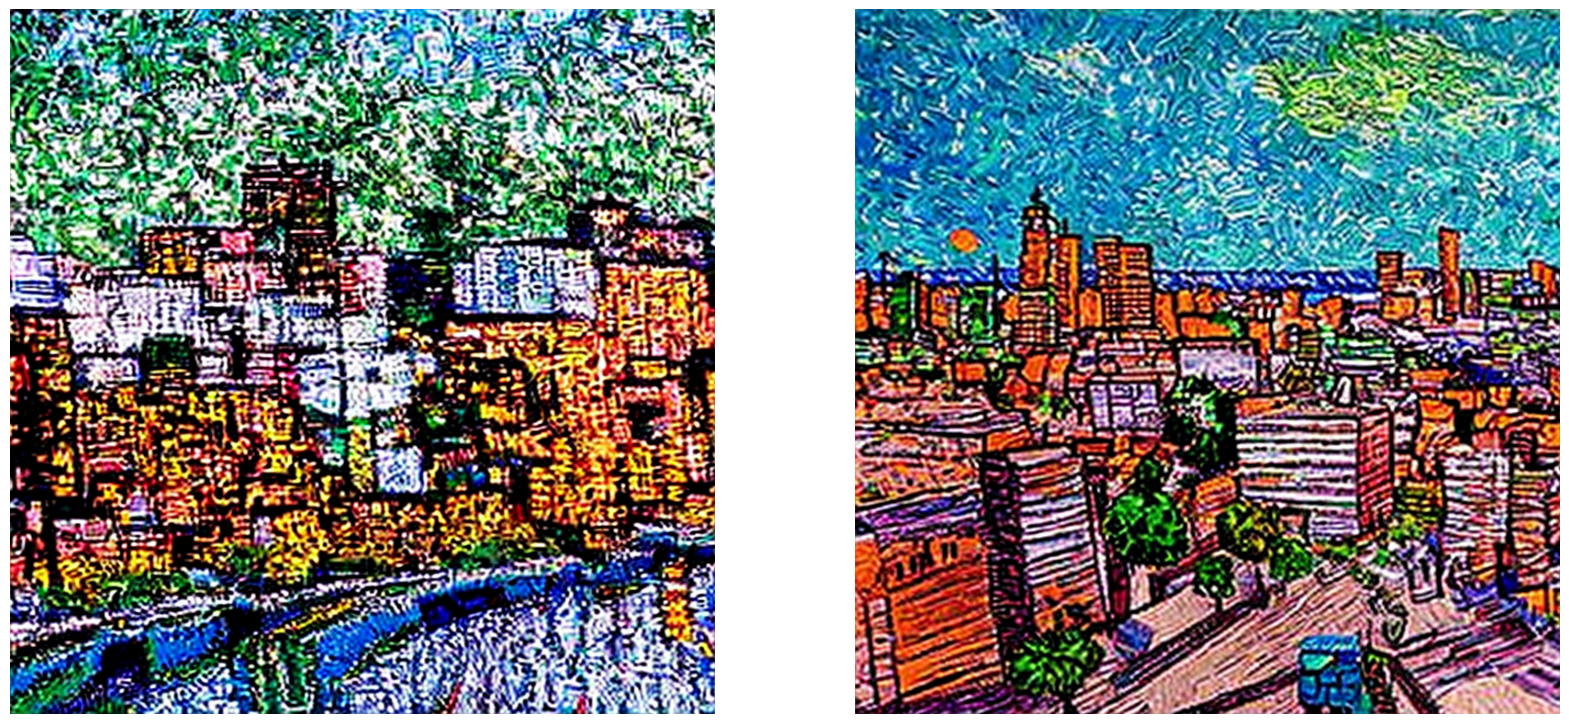

In [19]:
import os

# Create a directory to save the images if it doesn't exist
output_dir = "generated_images"
os.makedirs(output_dir, exist_ok=True)

# Define a prompt
prompt = "A painting of a city during day time with greenery very detailed in the style of Van Gogh"

# Generate images
images = pipe(prompt, num_images_per_prompt=2).images

# Save each image
for i, img in enumerate(images):
    img_path = os.path.join(output_dir, f"generated_image_{i+1}.png")
    img.save(img_path)
    print(f"Saved image {i+1} to {img_path}")

# You can still plot the images if you want
plot_images(images)


In [2]:
pipe.save_pretrained(output_dir)

Step 50/2000:
Total loss: 445.4956, Content loss: 19.7520, Style loss: 0.0000
Step 100/2000:
Total loss: 107.8149, Content loss: 19.9166, Style loss: 0.0000
Step 150/2000:
Total loss: 61.0755, Content loss: 19.7356, Style loss: 0.0000
Step 200/2000:
Total loss: 46.1048, Content loss: 19.4431, Style loss: 0.0000
Step 250/2000:
Total loss: 38.3988, Content loss: 19.1663, Style loss: 0.0000
Step 300/2000:
Total loss: 34.0040, Content loss: 18.8683, Style loss: 0.0000
Step 350/2000:
Total loss: 31.1710, Content loss: 18.6097, Style loss: 0.0000
Step 400/2000:
Total loss: 29.1901, Content loss: 18.3909, Style loss: 0.0000
Step 450/2000:
Total loss: 27.6845, Content loss: 18.1791, Style loss: 0.0000
Step 500/2000:
Total loss: 26.6015, Content loss: 17.9834, Style loss: 0.0000
Step 550/2000:
Total loss: 25.7582, Content loss: 17.8087, Style loss: 0.0000
Step 600/2000:
Total loss: 25.0919, Content loss: 17.6552, Style loss: 0.0000
Step 650/2000:
Total loss: 24.5861, Content loss: 17.5209, Styl

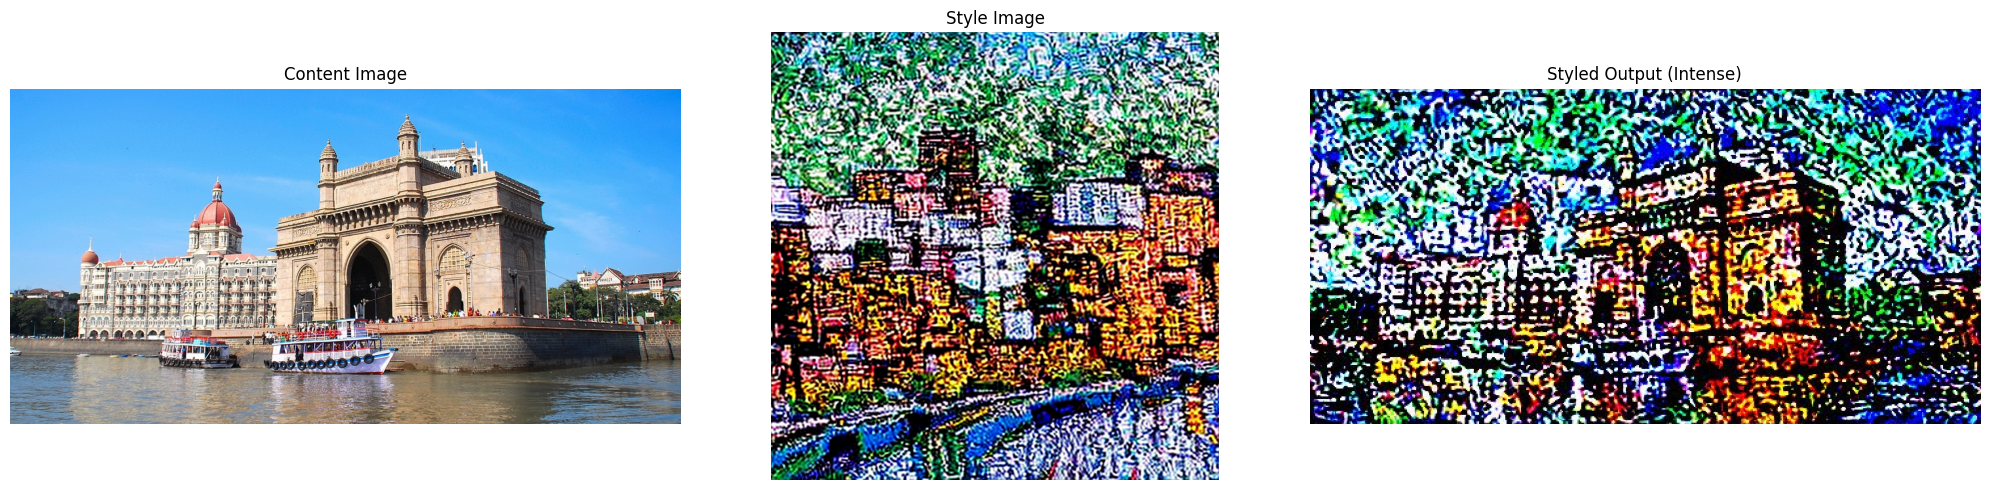

In [25]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt

vgg = models.vgg19(pretrained=True).features.eval()

content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

class StyleTransferModel(nn.Module):
    def __init__(self, content_img, style_img, device, content_layers=['21'],
                 style_layers=['0', '5', '10', '19', '28'], content_weight=1, style_weight=1e6):
        super(StyleTransferModel, self).__init__()
        self.device = device
        self.content_img = content_img
        self.style_img = style_img
        self.content_layers = content_layers
        self.style_layers = style_layers
        self.content_weight = content_weight
        self.style_weight = style_weight
        self.model = nn.Sequential(*list(vgg.children())[:29]).to(device)
        self.content_features = self.get_features(content_img, self.content_layers)
        self.style_features = self.get_features(style_img, self.style_layers)

    def get_features(self, x, layers):
        features = {}
        for name, layer in self.model._modules.items():
            x = layer(x)
            if name in layers:
                features[name] = x
        return features

    def gram_matrix(self, x):
        b, c, h, w = x.size()
        features = x.view(b * c, h * w)
        gram = torch.mm(features, features.t())
        return gram.div(b * c * h * w)

    def forward(self, x):
        content_loss = 0
        style_loss = 0

        features = self.get_features(x, self.content_layers + self.style_layers)

        for layer in self.content_layers:
            content_loss += nn.MSELoss()(features[layer], self.content_features[layer])

        for layer in self.style_layers:
            style_gram = self.gram_matrix(self.style_features[layer])
            input_gram = self.gram_matrix(features[layer])
            style_loss += nn.MSELoss()(input_gram, style_gram)

        total_loss = self.content_weight * content_loss + self.style_weight * style_loss
        return total_loss, content_loss, style_loss

def load_image(image_path, max_size=None):
    image = Image.open(image_path).convert('RGB')
    if max_size:
        image.thumbnail((max_size, max_size), Image.LANCZOS)  # Use LANCZOS instead of ANTIALIAS

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = transform(image).unsqueeze(0)
    return image

def apply_style_transfer(content_path, style_path, num_steps=2000, content_weight=1, style_weight=1e6,
                         learning_rate=1, max_size=512):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    content_img = load_image(content_path, max_size).to(device)
    style_img = load_image(style_path, max_size).to(device)

    input_img = content_img.clone()

    model = StyleTransferModel(content_img, style_img, device, content_weight=content_weight,
                               style_weight=style_weight).to(device)

    optimizer = optim.LBFGS([input_img.requires_grad_()], lr=learning_rate, max_iter=20)

    step = [0]  # Use a list to allow modification in the closure
    while step[0] < num_steps:
        def closure():
            optimizer.zero_grad()
            loss, content_loss, style_loss = model(input_img)
            loss.backward(retain_graph=True)  # Add retain_graph=True here
            step[0] += 1
            if step[0] % 50 == 0 or step[0] == num_steps:
                print(f'Step {step[0]}/{num_steps}:')
                print(f'Total loss: {loss.item():.4f}, Content loss: {content_loss.item():.4f}, Style loss: {style_loss.item():.4f}')
            return loss

        optimizer.step(closure)

    return input_img

def plot_images(images, titles=None):
    fig, axs = plt.subplots(1, len(images), figsize=(20, 5))
    for i, img in enumerate(images):
        if isinstance(img, torch.Tensor):
            img = img.cpu().squeeze(0).permute(1, 2, 0).numpy()
            img = (img * 255).clip(0, 255).astype(np.uint8)
        axs[i].imshow(img)
        axs[i].axis('off')
        if titles and i < len(titles):
            axs[i].set_title(titles[i])
    plt.tight_layout()
    plt.show()
# Main execution remains the same as before

if __name__ == "__main__":
    output_dir = "generated_images"
    os.makedirs(output_dir, exist_ok=True)

    content_path = "/notebooks/generated_images/mumbai.jpeg"
    style_path = "/notebooks/generated_images/generated_image_1.png"

    # Apply style transfer with more intense parameters
    output = apply_style_transfer(
        content_path,
        style_path,
        num_steps=2000,  # Increased number of steps for more precision
        content_weight=1,
        style_weight=1e7,  # Increased style weight for stronger style application
        learning_rate=1,
        max_size=512
    )

    # Save the styled image
    output_path = os.path.join(output_dir, "styled_output_intense.jpg")
    save_image(output.cpu().squeeze(0), output_path)
    print(f"Styled image saved to {output_path}")

    # Load images for display
    content_image = Image.open(content_path)
    style_image = Image.open(style_path)
    styled_image = Image.open(output_path)

    # Plot images with titles
    plot_images([content_image, style_image, styled_image],
                titles=['Content Image', 'Style Image', 'Styled Output (Intense)'])

In [30]:
import shutil

model_dir = "/notebooks/Working/van-gogh-model"
zip_file = "/notebooks/Working/van-gogh-model.zip"

shutil.make_archive(zip_file.replace('.zip', ''), 'zip', model_dir)
print(f"Model zipped at {zip_file}")


Model zipped at /notebooks/Working/van-gogh-model.zip
